# Optical Character Recognition (OCR) with pytesseract

This notebook will demonstrate how to perform OCR using pytesseract which is a Python wrapper for Google's Tesseract-OCR Engine allowing to extract text from images.

## Install & Import Python libraries

In [1]:
# Libraries
import os
import re
import cv2
import PIL
import csv
import nltk
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# Print versions of libraries
print("Version of package cv2:", cv2.__version__)
print("Version of package re:", re.__version__)
print("Version of package pytesseract:", pytesseract.__version__)
print("Version of package nltk:", nltk.__version__)
print("Version of PIL:", PIL.__version__, "\n")

# Specify the path to Tesseract (for Linux)
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Get current working directory
print(os.getcwd())

Version of package cv2: 4.12.0
Version of package re: 2.2.1
Version of package pytesseract: 0.3.13
Version of package nltk: 3.9.2
Version of PIL: 12.0.0 

/workspaces/python_data_preparation


## Read and plot digital image of the receipt

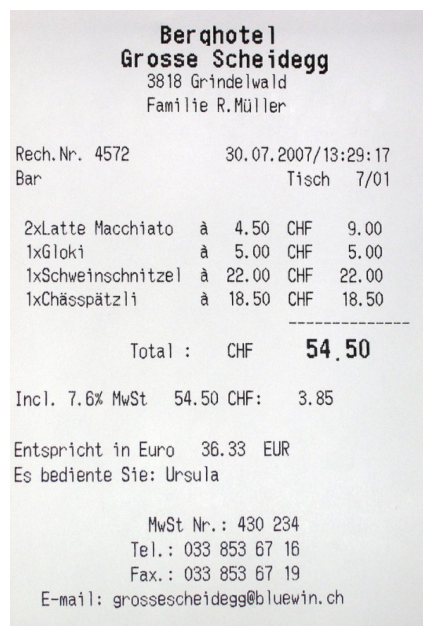

In [2]:
# Import receipt
img = cv2.imread('./Data/receipt.png')

# Functionto plot image
def plot_image(img, base_height=10):

    # Convert image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Define base height and calculate aspect ratio
    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (base_height * aspect_ratio, base_height)

    # Plot image of receipt
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Plot image of receipt
plot_image(img, 8)

## Image processing to improve the image quality

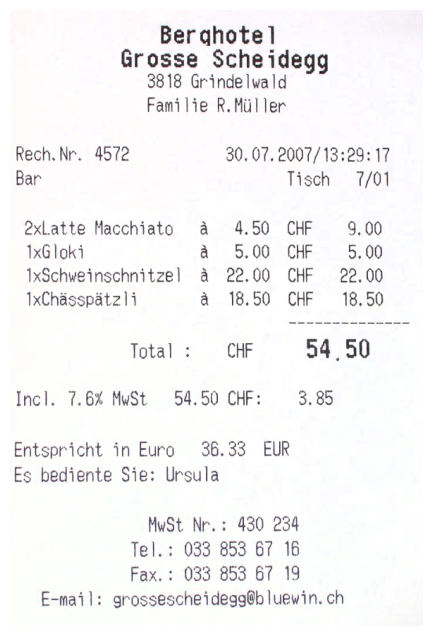

In [3]:
# Increase brightness function
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# Improve image quality step by step
img_01 = cv2.imread('./Data/receipt.png')
img = increase_brightness(img_01, value=30) 

# Plot image of receipt
plot_image(img, 8)

## Getting boxes around the text

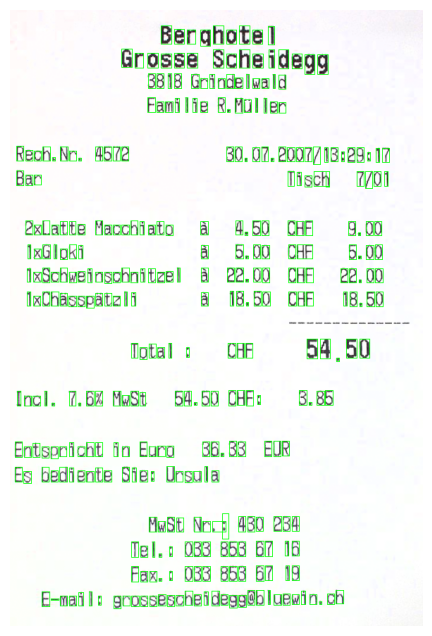

In [4]:
# Get image dimensions
h, w, c = img.shape

# Get OCR boxes
boxes = pytesseract.image_to_boxes(img, lang='deu')

# Draw boxes on the image
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 1)

# Get OCR data
d = pytesseract.image_to_data(img, output_type=Output.DICT, lang='deu')

# Plot image of receipt
plot_image(img, 8)

## Template Matching to extract numbers

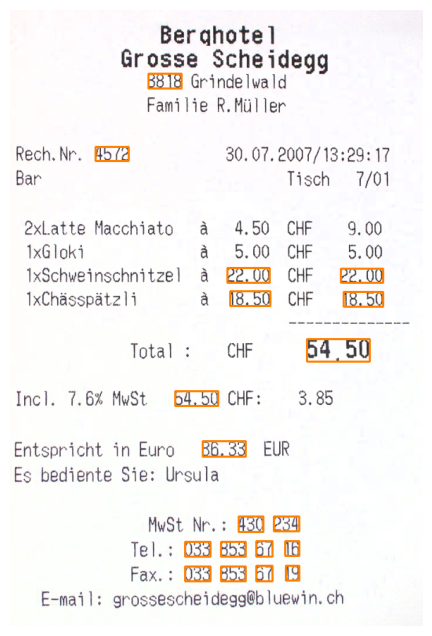

In [5]:
# # Import receipt and increase brightness
img_01 = cv2.imread('./Data/receipt.png')
img = increase_brightness(img_01, value=30) 

# Performs OCR on the input image and returns information about the text
d = pytesseract.image_to_data(img, output_type=Output.DICT, lang='deu')
keys = list(d.keys())
vals = list(d.values())

# Mark all numbers using regexpression
pattern = '[0-9][0-9]'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) >= 20:
        if re.match(pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0,128,255), 2)

# Plot image of receipt
plot_image(img, 8)

## Print content of boxes around the text

In [6]:
# Total number of text-boxes
print(f"Number of boxes: {n_boxes}", "\n")

# Boxes
boxes = pytesseract.image_to_boxes(img, lang='deu')
print(boxes[0:180])

# Keys
print(d.keys())

# Values
list(d.values())[11][17:21]

Number of boxes: 101 

B 214 827 229 853 0
e 233 827 247 848 0
r 251 827 263 847 0
g 270 824 284 847 0
h 288 827 303 853 0
o 307 827 321 847 0
t 325 827 340 853 0
e 344 827 358 847 0
l 366 826 375 852 0

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


['Rech.Nr.', '4572', '30.07.', '2007/13:29:17']

In [7]:
def replace_chars(text):
    """
    Replaces all characters instead of numbers from 'text'.
    :param text: Text string to be filtered
    :return: Resulting number
    """
    list_of_numbers = re.findall(r'\d+', text)
    result_number = '|'.join(list_of_numbers)
    return result_number

ocr_result = pytesseract.image_to_string(Image.open('./Data/receipt.png'), lang='deu')

print(ocr_result)

Berghotel
Grosse Scheidegg
3818 Grindelwald
Familie R.Müller

Rech. Nr. 4572 30. 07.2007/13:29:17
Bar Tisch 7/01
2xlLatte Macchiato & 4.50 CHF 9.00
1xGloki a 5.00. 7CHE 5.00
1xSchweinschnitzel A 22.00 CHF 22.00
1xChässpätz | i a 18,50% CHE 18450

Total: CHF 54,50
Incl. 7.6% MwSt 54.50 CHF: 3.85

Entspricht in Euro 36.33 EUR
Es bediente Sie: Ursula

MwSt Nr. : 430 234
Tel.:.033 88367 16
Fax.: 033. Buı 87.19
E-mail: grossescheidegg@bluewin. ch



## Write Text to File

In [8]:
parse_text = []
word_list  = []
last_word  = ''

for word in d['text']:
    if word!='':
        word_list.append(word)
        last_word = word
    if (last_word!='' and word == '') or (word==d['text'][-1]):
        parse_text.append(word_list)
        word_list = []

print(parse_text[:10])

# Write to .csv-file
with open('./Data/result_text.txt',  'w', newline="") as file:
          csv.writer(file, delimiter=" ").writerows(parse_text)

[['Berghotel'], ['Grosse', 'Scheidegg'], ['3818', 'Grindelwald'], ['Familie', 'R.Müller'], [], [], ['Rech.Nr.', '4572', '30.07.', '2007/13:29:17'], ['Bar', 'Tisch', '7/01'], ['&xlatte', 'Macchiato', 'A', '4.50', 'CHF', '9.00'], ['IxGloki', 'a', '5.00', 'CH', '5.00']]


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [9]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-10-20 07:40:24
Python Version: 3.11.14
-----------------------------------
